In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import functional as TF
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random
from torchvision.transforms.functional import InterpolationMode

In [2]:
class Brats2021LSTMDatasetLazy(Dataset):
    def __init__(self, subject_files, temporal=4, train=True, apply_augmentation_during_test=False):
        """
        subject_files: list of paths to preprocessed .npz files,
                       each containing 'volume' and 'label' arrays.
        temporal: number of slices per temporal window (for training)
        train: whether this is a training set or not
        apply_augmentation_during_test: whether to apply data augmentation during testing
        """
        self.subject_files = subject_files
        self.temporal = temporal
        self.is_train = train
        self.apply_augmentation_during_test = apply_augmentation_during_test

        self.freq = np.zeros(5)
        self.data = []

        print('~' * 50)
        print('******** Loading data********')

        count = 0
        # First pass: compute frequency and determine slices/entries
        for file_path in self.subject_files:
            count += 1
            if count % 10 == 0:
                print('Processing subject %d/%d' % (count, len(self.subject_files)))

            volume, label = self._load_subject(file_path)
            self.freq += self._get_freq(label) # Store the label of each subject to get the distributon and then calculate weights

            if self.is_train:
                # Training: sample temporal windows
                img_starts = self._compute_training_slices(volume)
                for start in img_starts:
                    self.data.append((file_path, start))
            else:
                # Validation/test: store entire subject
                self.data.append((file_path, None))

        self.freq = self.freq / np.sum(self.freq)
        self.weight = np.median(self.freq) / (self.freq + 1e-8) # Median weight used, same as the one proposed in the original paper
        print('******** Finished setup ********')
        print('Number of entries in this split:', len(self.data))
        print('********  Temporal length is %d ********' % self.temporal)
        print('********  Weight for all classes  ********')
        print(self.weight)
        print('~' * 50)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        """
        For training:
            We have (file_path, start_slice) and we load just that temporal window.
        For testing:
            We have (file_path, None) and we load the full subject.
        """
        file_path, start = self.data[index]
        volume, label = self._load_subject(file_path)

        if self.is_train:
            # Extract the temporal window
            images_vol, labels_vol, names = self._extract_window(volume, label, file_path, start or 0)
            
            # Apply data augmentation
            images_aug = []
            labels_aug = []
            for i in range(images_vol.shape[0]):
                augment_type = random.choices(
                    ["none", "gaussian", "low_res", "rotation", "gaussian_rotation", "low_res_rotation", "all"],
                    weights=[0.5, 0.1, 0.1, 0.1, 0.05, 0.05, 0.1], k=1
                )[0]
                image = images_vol[i]
                label = labels_vol[i]
                if augment_type == "gaussian":
                    image = self.add_noise(image, noise_type="gaussian", mean=0, std=0.05)
                    image = self.normalize_image_per_channel(image)
                elif augment_type == "low_res":
                    image = self.add_low_resolution(image, scale_factor=0.5)
                    image = self.normalize_image_per_channel(image)
                elif augment_type == "rotation":
                    image, label = self.add_rotation(image, label, angle_choices=[90, 180, 270])
                    # Re-normalization may not be necessary here
                elif augment_type == "gaussian_rotation":
                    image = self.add_noise(image, noise_type="gaussian", mean=0, std=0.05)
                    image, label = self.add_rotation(image, label, angle_choices=[90, 180, 270])
                    image = self.normalize_image_per_channel(image)
                elif augment_type == "low_res_rotation":
                    image = self.add_low_resolution(image, scale_factor=0.5)
                    image, label = self.add_rotation(image, label, angle_choices=[90, 180, 270])
                    image = self.normalize_image_per_channel(image)
                elif augment_type == "all":
                    image = self.add_noise(image, noise_type="gaussian", mean=0, std=0.05)
                    image = self.add_low_resolution(image, scale_factor=0.5)
                    image, label = self.add_rotation(image, label, angle_choices=[90, 180, 270])
                    image = self.normalize_image_per_channel(image)
                # else "none", do nothing
                    
                images_aug.append(image)
                labels_aug.append(label)
            images_vol = torch.stack(images_aug)
            labels_vol = torch.stack(labels_aug)
        else:
            # Testing
            D = volume.shape[1]
            images_vol = []
            labels_vol = []
            if self.apply_augmentation_during_test:
                # Apply augmentation to each slice
                for i in range(D):
                    image = torch.from_numpy(volume[:, i, :, :])   # (4,H,W)
                    lbl = torch.from_numpy(label[i, :, :])         # (H,W)
                    # Apply data augmentation
                    # [Use the same augmentation logic as in training]
                    # Apply data augmentation
                    augment_type = random.choices(
                        ["none", "rician", "low_res", "rotation", "rician_rotation", "low_res_rotation", "all"],
                        weights=[0, 0.2, 0.2, 0.2, 0.1, 0.1, 0.2], k=1
                    )[0]
                    if augment_type == "rician":
                        image = self.add_noise(image, noise_type="rician", mean=0, std=0.05)
                    elif augment_type == "low_res":
                        image = self.add_low_resolution(image, scale_factor=0.5)
                    elif augment_type == "rotation":
                        image, lbl = self.add_rotation(image, lbl, angle_choices=[90, 180, 270])
                    elif augment_type == "rician_rotation":
                        image = self.add_noise(image, noise_type="rician", mean=0, std=0.05)
                        image, lbl = self.add_rotation(image, lbl, angle_choices=[90, 180, 270])
                    elif augment_type == "low_res_rotation":
                        image = self.add_low_resolution(image, scale_factor=0.5)
                        image, lbl = self.add_rotation(image, lbl, angle_choices=[90, 180, 270])
                    elif augment_type == "all":
                        image = self.add_noise(image, noise_type="rician", mean=0, std=0.05)
                        image = self.add_low_resolution(image, scale_factor=0.5)
                        image, lbl = self.add_rotation(image, lbl, angle_choices=[90, 180, 270])
                    # else "none", do nothing

                    images_vol.append(image)  # (4,H,W)
                    labels_vol.append(lbl)    # (H,W)
                images_vol = torch.stack(images_vol)  # (D,4,H,W)
                labels_vol = torch.stack(labels_vol)  # (D,H,W)
                names = [file_path]
            else:
                # Return full volume without augmentation
                volume = torch.from_numpy(volume.transpose(1,0,2,3))  # (D,4,H,W)
                labels_vol = torch.from_numpy(label)
                images_vol = volume
                names = [file_path]

        return images_vol, labels_vol, names

    def _load_subject(self, file_path):
        """
        Loads a subject from a .npz file.
        The .npz file must contain:
          volume: (4,D,H,W) preprocessed volume
          label:  (D,H,W) segmentation labels
        """
        data = np.load(file_path)
        volume = data['volume']  # (4,D,H,W)
        label = data['label']    # (D,H,W)
        return volume, label

    def _compute_training_slices(self, volume):
        """
        Determine where to sample temporal windows from.
        Similar logic as the original paper:
        Find non-zero start and end, then pick random windows.
        """
        D = volume.shape[1]
        H = volume.shape[2]
        W = volume.shape[3]

        zero_vol = np.zeros((4,H,W))
        no_zero_start = 0
        no_zero_end = D

        # We keep checking until we find a non-zero start and end, by non-zero start we mean a slice that doesn't contain only the background
        for i in range(D):
            if not np.all(volume[:, i, :, :] == zero_vol):
                no_zero_start = i
                break

        for i in range(no_zero_start, D):
            if np.all(volume[:, i, :, :] == zero_vol):
                no_zero_end = i
                break

        num_slices = no_zero_end - no_zero_start
        times = int(num_slices / self.temporal)
        # Random offset
        rand_start = no_zero_start + np.random.randint(-self.temporal//2, self.temporal//2 + 1)

        img_starts = []
        for t in range(times):
            start_idx = rand_start + t * self.temporal
            # Adjust start_idx if it goes out of range
            start_idx = max(start_idx, no_zero_start)
            if start_idx + self.temporal <= no_zero_end:
                img_starts.append(start_idx)

        return img_starts

    def _extract_window(self, volume, label, file_path, start):
        """
        Extract a temporal window starting at 'start', start is a list containing start locations.
        Returns (temporal,4,H,W) volume and (temporal,H,W) label.
        """
        tmp_im = []
        tmp_lbl = []
        tmp_name = []
        # extract slices from the depth starting at the determined spots in the last function
        for i in range(start, start + self.temporal):
            tmp_im.append(torch.from_numpy(volume[:, i, :, :]))   # (4,H,W)
            tmp_lbl.append(torch.from_numpy(label[i, :, :]))       # (H,W)
            tmp_name.append(file_path + '=slice' + str(i))

        tmp_im = torch.stack(tmp_im)   # (temporal,4,H,W)
        tmp_lbl = torch.stack(tmp_lbl) # (temporal,H,W)
        return tmp_im, tmp_lbl, tmp_name

    @staticmethod
    def _get_freq(label):
        """
        Calculate frequency of each class in the label.
        label: (D,H,W)
        """
        class_count = np.zeros((5))
        for i in range(5):
            class_count[i] = np.sum(label == i)
        return class_count

    # Augmentation methods
    def add_noise(self, image, noise_type="gaussian", mean=0, std=0.05):
        """
        Adds Gaussian or rician noise to the image.
        image: tensor of shape (4, H, W)
        """
        if noise_type == "gaussian":
            noise = torch.randn_like(image) * std + mean
            image = image + noise
        elif noise_type == "rician":
            # Generate two independent Gaussian noises
            noise_real = torch.randn_like(image) * std + mean
            noise_imag = torch.randn_like(image) * std + mean
            # Combine them to simulate Rician noise
            image = torch.sqrt((image + noise_real) ** 2 + noise_imag ** 2)
        return image

    def add_low_resolution(self, image, scale_factor=0.5):
        """
        Downsamples the image and then upsamples it back to simulate low resolution.
        image: tensor of shape (4, H, W)
        """
        C, H, W = image.shape
        new_H, new_W = int(H * scale_factor), int(W * scale_factor)
        image = F.interpolate(image.unsqueeze(0), size=(new_H, new_W), mode='bilinear', align_corners=False)
        image = F.interpolate(image, size=(H, W), mode='bilinear', align_corners=False)
        return image.squeeze(0)

    def add_rotation(self, image, label, angle_choices=[90, 180, 270]):
        """
        Rotates the image and label by a random angle from angle_choices.
        image: tensor of shape (4, H, W)
        label: tensor of shape (H, W)
        """
        angle = random.choice(angle_choices)
        # Rotate image
        image = TF.rotate(image, angle, interpolation=InterpolationMode.BILINEAR)
        # Rotate label
        label = TF.rotate(label.unsqueeze(0), angle, interpolation=InterpolationMode.NEAREST).squeeze(0)
        return image, label
    def normalize_image_per_channel(self, image):
        """
        Normalizes each channel of the image to zero mean and unit variance.
        image: tensor of shape (C, H, W)
        """
        normalized_channels = []
        for c in range(image.shape[0]):
            channel = image[c]
            mean = torch.mean(channel)
            std = torch.std(channel)
            std = std if std > 0 else 1e-8  # Prevent division by zero
            channel = (channel - mean) / std
            normalized_channels.append(channel)
        normalized_image = torch.stack(normalized_channels)
        return normalized_image

In [3]:
# Get all subject directories
data_dir = '/kaggle/input/brats2021-preprocessed/content/brats21-dataset-preprocessed'
all_subjects = [os.path.join(data_dir, s) for s in os.listdir(data_dir)
                if s.endswith('.npz')]


np.random.seed(42)  # for reproducibility
np.random.shuffle(all_subjects)

# Split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

total = len(all_subjects)
train_count = int(train_ratio * total)
val_count = int(val_ratio * total)

train_subjects = all_subjects[:train_count]
val_subjects = all_subjects[train_count:train_count+val_count]
test_subjects = all_subjects[train_count+val_count:]

In [4]:
#train_dataset = Brats2021LSTMDatasetLazy(train_subjects, temporal=4, train=True)
test_dataset_not_noisy = Brats2021LSTMDatasetLazy(test_subjects, temporal=4, train=False, apply_augmentation_during_test=False)
test_dataset_noisy = Brats2021LSTMDatasetLazy(test_subjects, temporal=4, train=False, apply_augmentation_during_test=True)


test_loader_not_noisy = DataLoader(test_dataset_not_noisy, batch_size=4, pin_memory=True, shuffle=False, num_workers=2)
test_loader_noisy = DataLoader(test_dataset_noisy, batch_size=4, pin_memory=True, shuffle=False, num_workers=2)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
******** Loading data********
Processing subject 10/189
Processing subject 20/189
Processing subject 30/189
Processing subject 40/189
Processing subject 50/189
Processing subject 60/189
Processing subject 70/189
Processing subject 80/189
Processing subject 90/189
Processing subject 100/189
Processing subject 110/189
Processing subject 120/189
Processing subject 130/189
Processing subject 140/189
Processing subject 150/189
Processing subject 160/189
Processing subject 170/189
Processing subject 180/189
******** Finished setup ********
Number of entries in this split: 189
********  Temporal length is 4 ********
********  Weight for all classes  ********
[2.45576478e-03 1.65024324e+00 3.71285850e-01 2.43010753e+05
 9.99995885e-01]
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
******** Loading data********
Processing subject 10/189
Processing subject 20/189
Processing subject 30/189
P

In [5]:
# Defining blocks
#ConvBlock2d
class ConvBlock2d(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvBlock2d, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

# ConvTrans2d
class ConvTrans2d(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(ConvTrans2d, self).__init__()
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_ch, out_ch, kernel_size=3, stride=2, padding=1, output_padding=1
            ),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv1(x)

#UpBlock2d
class UpBlock2d(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UpBlock2d, self).__init__()
        self.up_conv = ConvTrans2d(in_ch, out_ch)
        self.conv = ConvBlock2d(2 * out_ch, out_ch)

    def forward(self, x, down_features):
        x = self.up_conv(x)  # Upsample
        x = torch.cat([x, down_features], dim=1)  # Concatenate with features from encoder
        x = self.conv(x)  # Apply convolutions
        return x

#MaxPool2d
class MaxPool2d(nn.Module):
    def __init__(self, kernel_size=2, stride=2, padding=0):
        super(MaxPool2d, self).__init__()
        self.pool = nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        return self.pool(x)

#ConvBlock
class ConvBlock(nn.Module):
    def __init__(self, in_dim, out_dim, act_fn, kernel_size=3, stride=1, padding=1):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, out_dim, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.BatchNorm2d(out_dim),
            act_fn,
        )

    def forward(self, x):
        return self.conv(x)

def croppCenter(tensorToCrop,finalShape):
    org_shape = tensorToCrop.shape

    diff = np.zeros(2)
    diff[0] = org_shape[2] - finalShape[2]
    diff[1] = org_shape[3] - finalShape[3]

    croppBorders = np.zeros(2,dtype=int)
    croppBorders[0] = int(diff[0]/2)
    croppBorders[1] = int(diff[1]/2)

    return tensorToCrop[:, :,
                        croppBorders[0]:croppBorders[0] + finalShape[2],
                        croppBorders[1]:croppBorders[1] + finalShape[3]]

In [6]:
class MMUnet(nn.Module):
    """Multi-Modal-Unet"""
    def __init__(self, input_nc, output_nc=5, ngf=32):
        super(MMUnet, self).__init__()
        print('~' * 50)
        print(' ----- Creating MULTI_UNET  ...')
        print('~' * 50)

        self.in_dim = input_nc
        self.out_dim = ngf
        self.final_out_dim = output_nc

        # Define the max pooling operation using the provided MaxPool2d class
        self.maxpool = MaxPool2d(kernel_size=2, stride=2)

        # ~~~ Encoding Paths ~~~~~~ #
        # Encoder (Modality 1)
        self.down_1_0 = ConvBlock2d(1, self.out_dim)
        self.pool_1_0 = self.maxpool
        self.down_2_0 = ConvBlock2d(self.out_dim * 4, self.out_dim * 2)
        self.pool_2_0 = self.maxpool
        self.down_3_0 = ConvBlock2d(self.out_dim * 12, self.out_dim * 4)
        self.pool_3_0 = self.maxpool
        self.down_4_0 = ConvBlock2d(self.out_dim * 28, self.out_dim * 8)
        self.pool_4_0 = self.maxpool

        # Encoder (Modality 2)
        self.down_1_1 = ConvBlock2d(1, self.out_dim)
        self.pool_1_1 = self.maxpool
        self.down_2_1 = ConvBlock2d(self.out_dim * 4, self.out_dim * 2)
        self.pool_2_1 = self.maxpool
        self.down_3_1 = ConvBlock2d(self.out_dim * 12, self.out_dim * 4)
        self.pool_3_1 = self.maxpool
        self.down_4_1 = ConvBlock2d(self.out_dim * 28, self.out_dim * 8)
        self.pool_4_1 = self.maxpool

        # Encoder (Modality 3)
        self.down_1_2 = ConvBlock2d(1, self.out_dim)
        self.pool_1_2 = self.maxpool
        self.down_2_2 = ConvBlock2d(self.out_dim * 4, self.out_dim * 2)
        self.pool_2_2 = self.maxpool
        self.down_3_2 = ConvBlock2d(self.out_dim * 12, self.out_dim * 4)
        self.pool_3_2 = self.maxpool
        self.down_4_2 = ConvBlock2d(self.out_dim * 28, self.out_dim * 8)
        self.pool_4_2 = self.maxpool

        # Encoder (Modality 4)
        self.down_1_3 = ConvBlock2d(1, self.out_dim)
        self.pool_1_3 = self.maxpool
        self.down_2_3 = ConvBlock2d(self.out_dim * 4, self.out_dim * 2)
        self.pool_2_3 = self.maxpool
        self.down_3_3 = ConvBlock2d(self.out_dim * 12, self.out_dim * 4)
        self.pool_3_3 = self.maxpool
        self.down_4_3 = ConvBlock2d(self.out_dim * 28, self.out_dim * 8)
        self.pool_4_3 = self.maxpool

        # Bridge
        self.bridge = ConvBlock2d(self.out_dim * 60, self.out_dim * 16)

        # ~~~ Decoding Path ~~~~~~ #
        self.upLayer1 = UpBlock2d(self.out_dim * 16, self.out_dim * 8)
        self.upLayer2 = UpBlock2d(self.out_dim * 8, self.out_dim * 4)
        self.upLayer3 = UpBlock2d(self.out_dim * 4, self.out_dim * 2)
        self.upLayer4 = UpBlock2d(self.out_dim * 2, self.out_dim * 1)

    def forward(self, input):
        # Split input by modality
        i0 = input[:, 0:1, :, :]
        i1 = input[:, 1:2, :, :]
        i2 = input[:, 2:3, :, :]
        i3 = input[:, 3:4, :, :]

        # First level
        down_1_0 = self.down_1_0(i0)
        down_1_1 = self.down_1_1(i1)
        down_1_2 = self.down_1_2(i2)
        down_1_3 = self.down_1_3(i3)

        # Second level inputs
        input_2nd_0 = torch.cat((self.pool_1_0(down_1_0),
                                 self.pool_1_1(down_1_1),
                                 self.pool_1_2(down_1_2),
                                 self.pool_1_3(down_1_3)), dim=1)

        input_2nd_1 = torch.cat((self.pool_1_1(down_1_1),
                                 self.pool_1_2(down_1_2),
                                 self.pool_1_3(down_1_3),
                                 self.pool_1_0(down_1_0)), dim=1)

        input_2nd_2 = torch.cat((self.pool_1_2(down_1_2),
                                 self.pool_1_3(down_1_3),
                                 self.pool_1_0(down_1_0),
                                 self.pool_1_1(down_1_1)), dim=1)

        input_2nd_3 = torch.cat((self.pool_1_3(down_1_3),
                                 self.pool_1_0(down_1_0),
                                 self.pool_1_1(down_1_1),
                                 self.pool_1_2(down_1_2)), dim=1)

        down_2_0 = self.down_2_0(input_2nd_0)
        down_2_1 = self.down_2_1(input_2nd_1)
        down_2_2 = self.down_2_2(input_2nd_2)
        down_2_3 = self.down_2_3(input_2nd_3)

        # Third level inputs
        down_2_0m = self.pool_2_0(down_2_0)
        down_2_1m = self.pool_2_1(down_2_1)
        down_2_2m = self.pool_2_2(down_2_2)
        down_2_3m = self.pool_2_3(down_2_3)

        input_3rd_0 = torch.cat((down_2_0m, down_2_1m, down_2_2m, down_2_3m), dim=1)
        input_3rd_0 = torch.cat((input_3rd_0, croppCenter(input_2nd_0, input_3rd_0.shape)), dim=1)

        input_3rd_1 = torch.cat((down_2_1m, down_2_2m, down_2_3m, down_2_0m), dim=1)
        input_3rd_1 = torch.cat((input_3rd_1, croppCenter(input_2nd_1, input_3rd_1.shape)), dim=1)

        input_3rd_2 = torch.cat((down_2_2m, down_2_3m, down_2_0m, down_2_1m), dim=1)
        input_3rd_2 = torch.cat((input_3rd_2, croppCenter(input_2nd_2, input_3rd_2.shape)), dim=1)

        input_3rd_3 = torch.cat((down_2_3m, down_2_0m, down_2_1m, down_2_2m), dim=1)
        input_3rd_3 = torch.cat((input_3rd_3, croppCenter(input_2nd_3, input_3rd_3.shape)), dim=1)

        down_3_0 = self.down_3_0(input_3rd_0)
        down_3_1 = self.down_3_1(input_3rd_1)
        down_3_2 = self.down_3_2(input_3rd_2)
        down_3_3 = self.down_3_3(input_3rd_3)

        # Fourth level inputs
        down_3_0m = self.pool_3_0(down_3_0)
        down_3_1m = self.pool_3_1(down_3_1)
        down_3_2m = self.pool_3_2(down_3_2)
        down_3_3m = self.pool_3_3(down_3_3)

        input_4th_0 = torch.cat((down_3_0m, down_3_1m, down_3_2m, down_3_3m), dim=1)
        input_4th_0 = torch.cat((input_4th_0, croppCenter(input_3rd_0, input_4th_0.shape)), dim=1)

        input_4th_1 = torch.cat((down_3_1m, down_3_2m, down_3_3m, down_3_0m), dim=1)
        input_4th_1 = torch.cat((input_4th_1, croppCenter(input_3rd_1, input_4th_1.shape)), dim=1)

        input_4th_2 = torch.cat((down_3_2m, down_3_3m, down_3_0m, down_3_1m), dim=1)
        input_4th_2 = torch.cat((input_4th_2, croppCenter(input_3rd_2, input_4th_2.shape)), dim=1)

        input_4th_3 = torch.cat((down_3_3m, down_3_0m, down_3_1m, down_3_2m), dim=1)
        input_4th_3 = torch.cat((input_4th_3, croppCenter(input_3rd_3, input_4th_3.shape)), dim=1)

        down_4_0 = self.down_4_0(input_4th_0)
        down_4_1 = self.down_4_1(input_4th_1)
        down_4_2 = self.down_4_2(input_4th_2)
        down_4_3 = self.down_4_3(input_4th_3)

        # Bridge
        down_4_0m = self.pool_4_0(down_4_0)
        down_4_1m = self.pool_4_1(down_4_1)
        down_4_2m = self.pool_4_2(down_4_2)
        down_4_3m = self.pool_4_3(down_4_3)

        inputBridge = torch.cat((down_4_0m, down_4_1m, down_4_2m, down_4_3m), dim=1)
        inputBridge = torch.cat((inputBridge, croppCenter(input_4th_0, inputBridge.shape)), dim=1)

        bridge = self.bridge(inputBridge)

        # Decoding path
        skip_1 = (down_4_0 + down_4_1 + down_4_2 + down_4_3) / 4.0
        skip_2 = (down_3_0 + down_3_1 + down_3_2 + down_3_3) / 4.0
        skip_3 = (down_2_0 + down_2_1 + down_2_2 + down_2_3) / 4.0
        skip_4 = (down_1_0 + down_1_1 + down_1_2 + down_1_3) / 4.0

        x = self.upLayer1(bridge, skip_1)
        x = self.upLayer2(x, skip_2)
        x = self.upLayer3(x, skip_3)
        x = self.upLayer4(x, skip_4)

        return x


class LSTM0(nn.Module):
    def __init__(self, in_c=5, ngf=32):
        super(LSTM0, self).__init__()
        # Using ConvBlock with Identity activation to emulate linear conv
        identity = nn.Identity()
        self.conv_gx_lstm0 = ConvBlock(in_c + ngf, ngf, identity)
        self.conv_ix_lstm0 = ConvBlock(in_c + ngf, ngf, identity)
        self.conv_ox_lstm0 = ConvBlock(in_c + ngf, ngf, identity)

    def forward(self, xt):
        # xt: bz * (5 + 32) * H * W
        gx = torch.tanh(self.conv_gx_lstm0(xt))
        ix = torch.sigmoid(self.conv_ix_lstm0(xt))
        ox = torch.sigmoid(self.conv_ox_lstm0(xt))

        cell_1 = torch.tanh(gx * ix)
        hide_1 = ox * cell_1
        return cell_1, hide_1


class LSTM(nn.Module):
    def __init__(self, in_c=5, ngf=32):
        super(LSTM, self).__init__()
        identity = nn.Identity()

        # For LSTM we have pairs of conv: one on xt and one on hide_t_1.
        # We'll create two ConvBlock layers and sum their outputs.
        # We'll store them as (conv_ix_lstm, conv_ih_lstm, ...) using ConvBlock:

        self.conv_ix_lstm = ConvBlock(in_c + ngf, ngf, identity)
        self.conv_ih_lstm = ConvBlock(ngf, ngf, identity)

        self.conv_fx_lstm = ConvBlock(in_c + ngf, ngf, identity)
        self.conv_fh_lstm = ConvBlock(ngf, ngf, identity)

        self.conv_ox_lstm = ConvBlock(in_c + ngf, ngf, identity)
        self.conv_oh_lstm = ConvBlock(ngf, ngf, identity)

        self.conv_gx_lstm = ConvBlock(in_c + ngf, ngf, identity)
        self.conv_gh_lstm = ConvBlock(ngf, ngf, identity)

    def forward(self, xt, cell_t_1, hide_t_1):
        gx = self.conv_gx_lstm(xt)
        gh = self.conv_gh_lstm(hide_t_1)
        g_sum = gx + gh
        gt = torch.tanh(g_sum)

        ox = self.conv_ox_lstm(xt)
        oh = self.conv_oh_lstm(hide_t_1)
        o_sum = ox + oh
        ot = torch.sigmoid(o_sum)

        ix = self.conv_ix_lstm(xt)
        ih = self.conv_ih_lstm(hide_t_1)
        i_sum = ix + ih
        it = torch.sigmoid(i_sum)

        fx = self.conv_fx_lstm(xt)
        fh = self.conv_fh_lstm(hide_t_1)
        f_sum = fx + fh
        ft = torch.sigmoid(f_sum)

        cell_t = ft * cell_t_1 + it * gt
        hide_t = ot * torch.tanh(cell_t)

        return cell_t, hide_t


class LSTM_MMUnet(nn.Module):
    def __init__(self, input_nc=1, output_nc=5, ngf=32, temporal=3):
        super(LSTM_MMUnet, self).__init__()
        self.temporal = temporal
        self.mmunet = MMUnet(input_nc, output_nc, ngf)
        self.lstm0 = LSTM0(in_c=output_nc, ngf=ngf)
        self.lstm = LSTM(in_c=output_nc, ngf=ngf)

        # Using ConvBlock to replace direct Conv2d layers for output
        # For the output convolution, we can still use ConvBlock with Identity and then a final activation outside if needed.
        identity = nn.Identity()

        # mmout and out: originally were Conv2d. Now replaced with ConvBlock followed by extracting just conv from it.
        # However, we must produce final output without BN/activation. Let's just use ConvBlock and note that it introduces BN.
        # If strictly needed linear: we can add Identity after block and rely on user's acceptance of BN here.
        self.mmout_block = ConvBlock(ngf, output_nc, identity)
        self.out_block = ConvBlock(ngf, output_nc, identity)

    def forward(self, x):
        """
        :param x: bz * temporal * 4 * H * W
        """
        output = []
        mm_output = []
        cell = None
        hide = None
        for t in range(self.temporal):
            im_t = x[:, t, :, :, :]
            mm_last = self.mmunet(im_t)        # bz * ngf(32) * H * W
            out_t_mm = self.mmout_block(mm_last)  # bz * output_nc(5) * H * W
            mm_output.append(out_t_mm)

            lstm_in = torch.cat((out_t_mm, mm_last), dim=1) # bz * (5+32) * H * W

            if t == 0:
                cell, hide = self.lstm0(lstm_in)
            else:
                cell, hide = self.lstm(lstm_in, cell, hide)

            out_t = self.out_block(hide)
            output.append(out_t)

        return torch.stack(mm_output, dim=1), torch.stack(output, dim=1)


In [7]:
# Initialize models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_noisy = LSTM_MMUnet(input_nc=1, output_nc=5, ngf=32, temporal=4).to(device)
model_not_noisy = LSTM_MMUnet(input_nc=1, output_nc=5, ngf=32, temporal=4).to(device)

#weight = torch.from_numpy(train_dataset.weight).float()    # weight for all classes
#weight = weight.to(device)
#criterion = nn.CrossEntropyLoss(weight = weight)

# Load state dictionaries
checkpoint_noisy = torch.load('/kaggle/input/final_models_lstm/pytorch/default/1/checkpoint_epoch_5_025noise.pth', map_location=device)
model_noisy.load_state_dict(checkpoint_noisy['model_state_dict'])

checkpoint_not_noisy = torch.load('/kaggle/input/final_models_lstm/pytorch/default/1/checkpoint_epoch_9.pth', map_location=device)
model_not_noisy.load_state_dict(checkpoint_not_noisy['model_state_dict'])

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 ----- Creating MULTI_UNET  ...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 ----- Creating MULTI_UNET  ...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


<ipython-input-7-d4fcde493ac5>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_noisy = torch.load('/kaggle/input/final_models_lstm/pytorch/default/1/checkpoint_

<All keys matched successfully>

In [8]:
def compute_metrics(preds, labels):
    """
    Compute accuracy, dice, F-score, sensitivity, precision, specificity, and IoU for multi-class segmentation.
    preds: (N, H, W) or (B,T,H,W) predicted labels
    labels: same shape as preds with ground truth labels
    """

    # Ensure preds and labels are CPU numpy arrays for easy manipulation
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()

    # shape could be (B,T,H,W). Let's combine B and T as one dimension:
    if preds.ndim == 4:
        # (B,T,H,W) => (B*T,H,W)
        BTHW = preds.shape[0]*preds.shape[1]
        preds = preds.reshape(BTHW, preds.shape[2], preds.shape[3])
        labels = labels.reshape(BTHW, labels.shape[2], labels.shape[3])
    else:
        BTHW = preds.shape[0]
    # Now preds and labels are (N,H,W)

    total_voxels = np.prod(preds.shape)
    accuracy = (preds == labels).sum() / total_voxels

    # Compute metrics per class
    dice_scores = []
    f_scores = []
    sensitivity_scores = []
    precision_scores = []
    specificity_scores = []
    iou_scores = []

    dice_per_class = {}
    f1_per_class = {}
    sensitivity_per_class = {}
    precision_per_class = {}
    specificity_per_class = {}
    iou_per_class = {}

    for c in [0,1,2,4]:
        pred_c = (preds == c)
        label_c = (labels == c)

        # intersection = TP
        intersection = np.logical_and(pred_c, label_c).sum()
        pred_c_sum = pred_c.sum()
        label_c_sum = label_c.sum()

        # TP, FP, FN, TN
        TP = intersection
        FP = pred_c_sum - intersection
        FN = label_c_sum - intersection
        TN = total_voxels - (TP + FP + FN)

        # Dice = (2 * TP) / (2 * TP + FP + FN)
        if pred_c_sum + label_c_sum > 0:
            dice_c = (2.0 * TP) / (pred_c_sum + label_c_sum)
        else:
            dice_c = 1.0 if pred_c_sum == 0 and label_c_sum == 0 else 0.0

        # F1 Score is the same as Dice for binary classification
        f1_c = dice_c

        # Sensitivity (Recall) = TP / (TP + FN)
        if (TP + FN) > 0:
            sensitivity_c = TP / (TP + FN)
        else:
            sensitivity_c = 0.0

        # Precision = TP / (TP + FP)
        if (TP + FP) > 0:
            precision_c = TP / (TP + FP)
        else:
            precision_c = 0.0

        # Specificity = TN / (TN + FP)
        if (TN + FP) > 0:
            specificity_c = TN / (TN + FP)
        else:
            specificity_c = 0.0

        # IoU = TP / (TP + FP + FN)
        denominator = TP + FP + FN
        if denominator > 0:
            iou_c = TP / denominator
        else:
            iou_c = 1.0 if TP == 0 and FP == 0 and FN == 0 else 0.0

        # Store metrics
        dice_scores.append(dice_c)
        f_scores.append(f1_c)
        sensitivity_scores.append(sensitivity_c)
        precision_scores.append(precision_c)
        specificity_scores.append(specificity_c)
        iou_scores.append(iou_c)

        dice_per_class[c] = dice_c
        f1_per_class[c] = f1_c
        sensitivity_per_class[c] = sensitivity_c
        precision_per_class[c] = precision_c
        specificity_per_class[c] = specificity_c
        iou_per_class[c] = iou_c

    # Compute averages over classes
    dice_avg = np.mean(dice_scores)
    f1_avg = np.mean(f_scores)
    sensitivity_avg = np.mean(sensitivity_scores)
    precision_avg = np.mean(precision_scores)
    specificity_avg = np.mean(specificity_scores)
    iou_avg = np.mean(iou_scores)

    return (accuracy, dice_avg, f1_avg, sensitivity_avg, precision_avg, specificity_avg, iou_avg,
            dice_per_class, f1_per_class, sensitivity_per_class, precision_per_class, specificity_per_class, iou_per_class)

In [9]:
def test_model(model, test_loader):
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    test_dice = 0.0
    test_f1 = 0.0
    test_sensitivity = 0.0
    test_precision = 0.0
    test_specificity = 0.0
    test_iou = 0.0
    count = 0

    # To accumulate per-class metrics
    classes = [0,1,2,4]

    # Initialize per-class metric sums
    dice_per_class_sum = {c:0.0 for c in classes}
    f1_per_class_sum = {c:0.0 for c in classes}
    sensitivity_per_class_sum = {c:0.0 for c in classes}
    precision_per_class_sum = {c:0.0 for c in classes}
    specificity_per_class_sum = {c:0.0 for c in classes}
    iou_per_class_sum = {c:0.0 for c in classes}

    temporal = 4

    with torch.no_grad():
        for batch_idx, (images, labels, names) in enumerate(test_loader):

            for t in range(0, 155 - temporal, temporal):
                image = images[:, t:t+temporal, ...]  # 5D tensor bs * temp * 4 * H * W
                label = labels[:, t:t+temporal, ...]  # 4D tensor bs * temp * H * W
                image = image.to(device)
                label = label.to(device)

                mm_output, output = model(image)
                B, T, C, H, W = output.shape
                output_flat = output.view(B*T, C, H, W)
                labels_flat = label.view(B*T, H, W)

                loss = criterion(output_flat, labels_flat)
                test_loss += loss.item()

                predictions = torch.argmax(output_flat, dim=1)  # (B*T,H,W)
                predictions = predictions.view(B, T, H, W)
                labs = labels_flat.view(B, T, H, W)

                metrics = compute_metrics(predictions, labs)
                (acc, dice_avg, f1_avg, sensitivity_avg, precision_avg, specificity_avg, iou_avg,
                 dice_per_class, f1_per_class, sensitivity_per_class, precision_per_class, specificity_per_class, iou_per_class) = metrics

                test_acc += acc
                test_dice += dice_avg
                test_f1 += f1_avg
                test_sensitivity += sensitivity_avg
                test_precision += precision_avg
                test_specificity += specificity_avg
                test_iou += iou_avg

                # Accumulate per-class metrics
                for c in classes:
                    dice_per_class_sum[c] += dice_per_class[c]
                    f1_per_class_sum[c] += f1_per_class[c]
                    sensitivity_per_class_sum[c] += sensitivity_per_class[c]
                    precision_per_class_sum[c] += precision_per_class[c]
                    specificity_per_class_sum[c] += specificity_per_class[c]
                    iou_per_class_sum[c] += iou_per_class[c]

                count += 1

    # Compute averages
    test_loss /= len(test_loader)
    test_acc /= count
    test_dice /= count
    test_f1 /= count
    test_sensitivity /= count
    test_precision /= count
    test_specificity /= count
    test_iou /= count

    dice_per_class_avg = {c: dice_per_class_sum[c]/count for c in classes}
    f1_per_class_avg = {c: f1_per_class_sum[c]/count for c in classes}
    sensitivity_per_class_avg = {c: sensitivity_per_class_sum[c]/count for c in classes}
    precision_per_class_avg = {c: precision_per_class_sum[c]/count for c in classes}
    specificity_per_class_avg = {c: specificity_per_class_sum[c]/count for c in classes}
    iou_per_class_avg = {c: iou_per_class_sum[c]/count for c in classes}

    # Prepare results
    results = {
        'loss': test_loss,
        'accuracy': test_acc,
        'dice': test_dice,
        'f1': test_f1,
        'sensitivity': test_sensitivity,
        'precision': test_precision,
        'specificity': test_specificity,
        'iou': test_iou,
        'dice_per_class': dice_per_class_avg,
        'f1_per_class': f1_per_class_avg,
        'sensitivity_per_class': sensitivity_per_class_avg,
        'precision_per_class': precision_per_class_avg,
        'specificity_per_class': specificity_per_class_avg,
        'iou_per_class': iou_per_class_avg
    }

    return results

In [10]:
def print_results(results):
    print(f"Test Loss: {results['loss']:.4f}, Acc: {results['accuracy']:.4f}, Dice: {results['dice']:.4f}, F1: {results['f1']:.4f}")
    print(f"Sensitivity: {results['sensitivity']:.4f}, Precision: {results['precision']:.4f}, Specificity: {results['specificity']:.4f}, IoU: {results['iou']:.4f}")
    print("\nPer-class metrics:")
    for c in results['dice_per_class']:
        print(f"Class {c}:")
        print(f"    Dice: {results['dice_per_class'][c]:.4f}")
        print(f"    F1 Score: {results['f1_per_class'][c]:.4f}")
        print(f"    Sensitivity: {results['sensitivity_per_class'][c]:.4f}")
        print(f"    Precision: {results['precision_per_class'][c]:.4f}")
        print(f"    Specificity: {results['specificity_per_class'][c]:.4f}")
        print(f"    IoU: {results['iou_per_class'][c]:.4f}")

print("\nTesting model trained on noisy data on noisy test data:")
results_noisy_model_on_noisy_test = test_model(model_noisy, test_loader_noisy)
print_results(results_noisy_model_on_noisy_test)

print("Testing model trained on noisy data on not noisy test data:")
results_noisy_model_on_clean_test = test_model(model_noisy, test_loader_not_noisy)
print_results(results_noisy_model_on_clean_test)

print("\nTesting model trained on not noisy data on not noisy test data:")
results_clean_model_on_clean_test = test_model(model_not_noisy, test_loader_not_noisy)
print_results(results_clean_model_on_clean_test)

print("\nTesting model trained on not noisy data on noisy test data:")
results_clean_model_on_noisy_test = test_model(model_not_noisy, test_loader_noisy)
print_results(results_clean_model_on_noisy_test)


Testing model trained on noisy data on noisy test data:
Test Loss: 7.8372, Acc: 0.9718, Dice: 0.4529, F1: 0.4529
Sensitivity: 0.6063, Precision: 0.3985, Specificity: 0.9024, IoU: 0.3976

Per-class metrics:
Class 0:
    Dice: 0.9859
    F1 Score: 0.9859
    Sensitivity: 0.9726
    Precision: 0.9999
    Specificity: 0.6379
    IoU: 0.9725
Class 1:
    Dice: 0.1687
    F1 Score: 0.1687
    Sensitivity: 0.3962
    Precision: 0.1136
    Specificity: 0.9912
    IoU: 0.1192
Class 2:
    Dice: 0.2547
    F1 Score: 0.2547
    Sensitivity: 0.5617
    Precision: 0.1781
    Specificity: 0.9825
    IoU: 0.1701
Class 4:
    Dice: 0.4025
    F1 Score: 0.4025
    Sensitivity: 0.4945
    Precision: 0.3025
    Specificity: 0.9981
    IoU: 0.3287
Testing model trained on noisy data on not noisy test data:
Test Loss: 6.2020, Acc: 0.9815, Dice: 0.5390, F1: 0.5390
Sensitivity: 0.6157, Precision: 0.4241, Specificity: 0.9055, IoU: 0.4833

Per-class metrics:
Class 0:
    Dice: 0.9909
    F1 Score: 0.9909
    

In [15]:
def visualize_model_predictions(model, test_loader, device, title):
    """
    Visualizes the model's predictions on a batch from the test loader.

    Parameters:
    - model: The trained model to use for predictions.
    - test_loader: The DataLoader for the test dataset.
    - device: The device to run the model on (cpu or cuda).
    - title: A string title to describe the visualization.
    """
    model.eval()
    
    # Select a batch from the test_loader
    with torch.no_grad():
        for batch_idx, (images, labels, names) in enumerate(test_loader):
            if batch_idx == 2:
                images = images.to(device)
                labels = labels.to(device)
                D = images.size(1)  # Depth of the volume
                
                temporal = 4  # Assuming temporal length is 4
                # Select a temporal window to pass through the model
                # Let's choose temporal indices from the middle of the volume
                temporal_start = D // 2
                temporal_end = temporal_start + temporal

                # Ensure we don't exceed the depth
                if temporal_end > D:
                    temporal_start = D - temporal
                    temporal_end = D
                if temporal_start < 0:
                    temporal_start = 0
                    temporal_end = temporal

                image = images[:, temporal_start:temporal_end, ...]  # Shape [B, temporal, C, H, W]
                label = labels[:, temporal_start:temporal_end, ...]  # Shape [B, temporal, H, W]

                # Run the model
                _, output = model(image)  # Output shape: [B, T, C, H, W]
                preds = torch.argmax(output, dim=2)  # Predicted mask, shape: [B, T, H, W]
                break  # Visualize just one batch

    # Convert tensors to numpy arrays for visualization
    image_np = image.cpu().numpy()
    label_np = label.cpu().numpy()
    preds_np = preds.cpu().numpy()

    # Select specific indices for visualization
    batch_idx = 0  # Since batch size is 1
    temporal_idx = 0  # First time index in temporal sequence
    modal_idx = 0  # First modality (you can choose from 0 to 3)

    specific_image = image_np[batch_idx, temporal_idx, modal_idx]  # Shape [H, W]
    specific_label = label_np[batch_idx, temporal_idx]  # Shape [H, W]
    specific_pred = preds_np[batch_idx, temporal_idx]  # Shape [H, W]

    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Input image
    axes[0].imshow(specific_image, cmap='gray')
    axes[0].set_title(f'Input Image (Modality={modal_idx})')

    # Ground Truth
    axes[1].imshow(specific_image, cmap='gray')
    axes[1].imshow(specific_label, cmap='viridis', alpha=0.5, vmin=0, vmax=3)
    axes[1].set_title('Ground Truth Label')

    # Predicted Mask
    axes[2].imshow(specific_image, cmap='gray')
    axes[2].imshow(specific_pred, cmap='viridis', alpha=0.5, vmin=0, vmax=3)
    axes[2].set_title('Predicted Mask')

    for ax in axes:
        ax.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

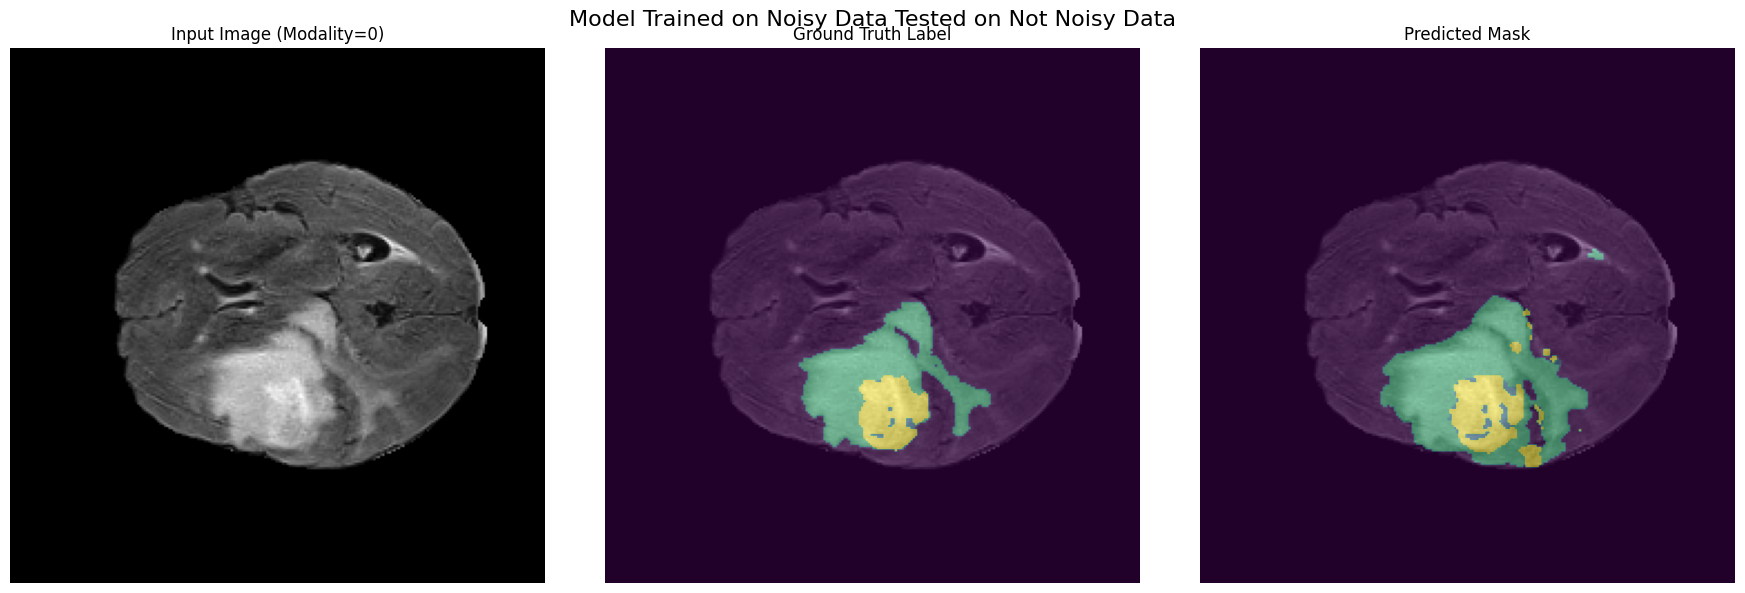

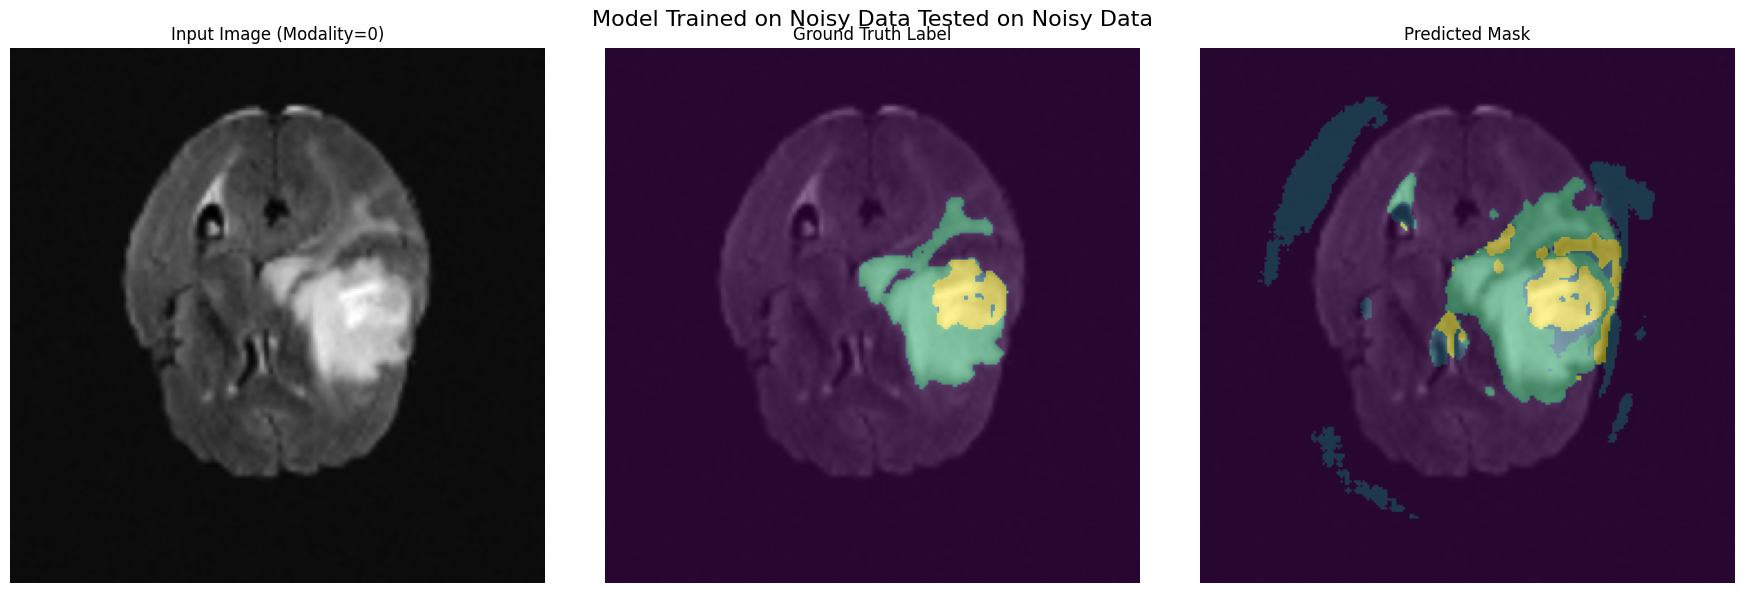

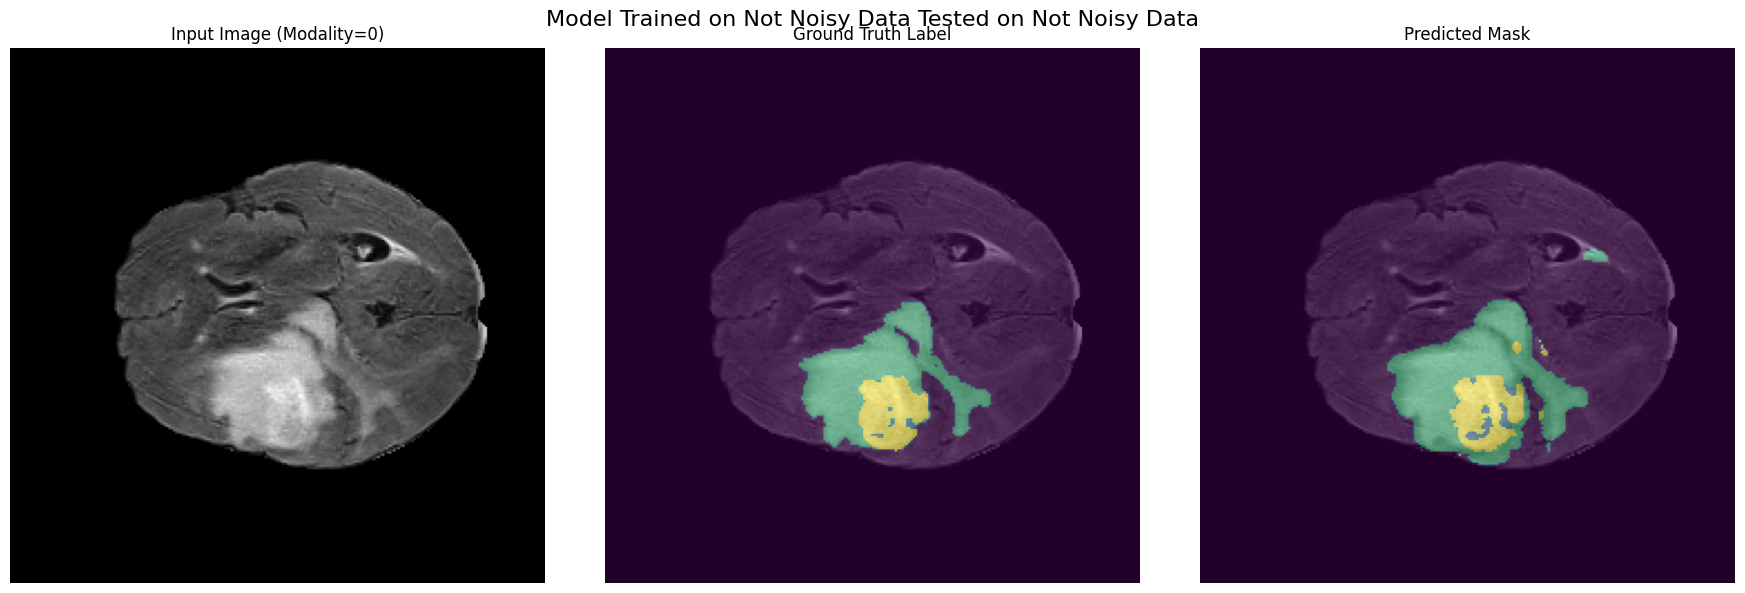

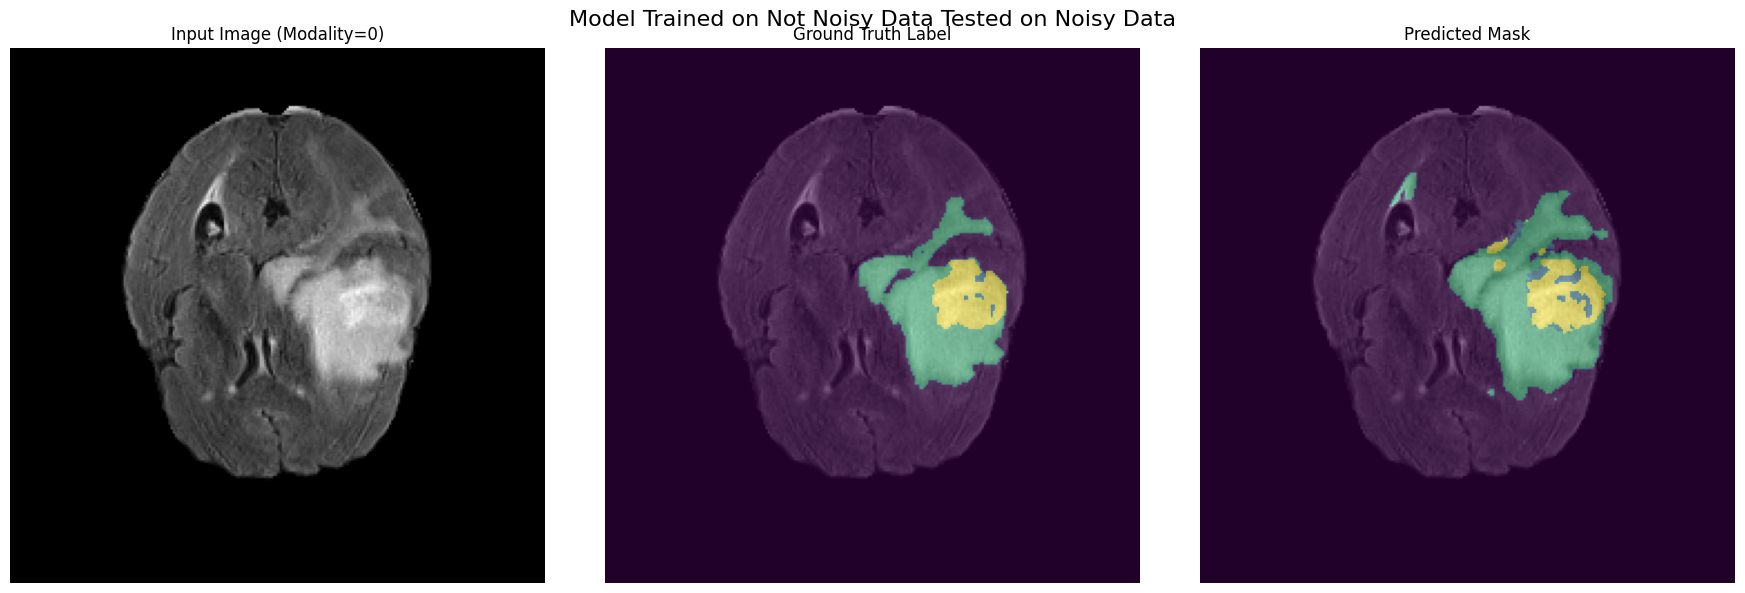

In [17]:
# Visualize Model Trained on Noisy Data Tested on Not Noisy Data
visualize_model_predictions(
    model=model_noisy,
    test_loader=test_loader_not_noisy,
    device=device,
    title='Model Trained on Noisy Data Tested on Not Noisy Data'
)

# Visualize Model Trained on Noisy Data Tested on Noisy Data
visualize_model_predictions(
    model=model_noisy,
    test_loader=test_loader_noisy,
    device=device,
    title='Model Trained on Noisy Data Tested on Noisy Data'
)

# Visualize Model Trained on Not Noisy Data Tested on Not Noisy Data
visualize_model_predictions(
    model=model_not_noisy,
    test_loader=test_loader_not_noisy,
    device=device,
    title='Model Trained on Not Noisy Data Tested on Not Noisy Data'
)

# Visualize Model Trained on Not Noisy Data Tested on Noisy Data
visualize_model_predictions(
    model=model_not_noisy,
    test_loader=test_loader_noisy,
    device=device,
    title='Model Trained on Not Noisy Data Tested on Noisy Data'
)

Registering hooks on layer: mmunet.upLayer4.conv.conv2


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Registering hooks on layer: mmunet.upLayer4.conv.conv2
Registering hooks on layer: mmunet.upLayer4.conv.conv2
Registering hooks on layer: mmunet.upLayer4.conv.conv2
Registering hooks on layer: mmunet.upLayer4.conv.conv2


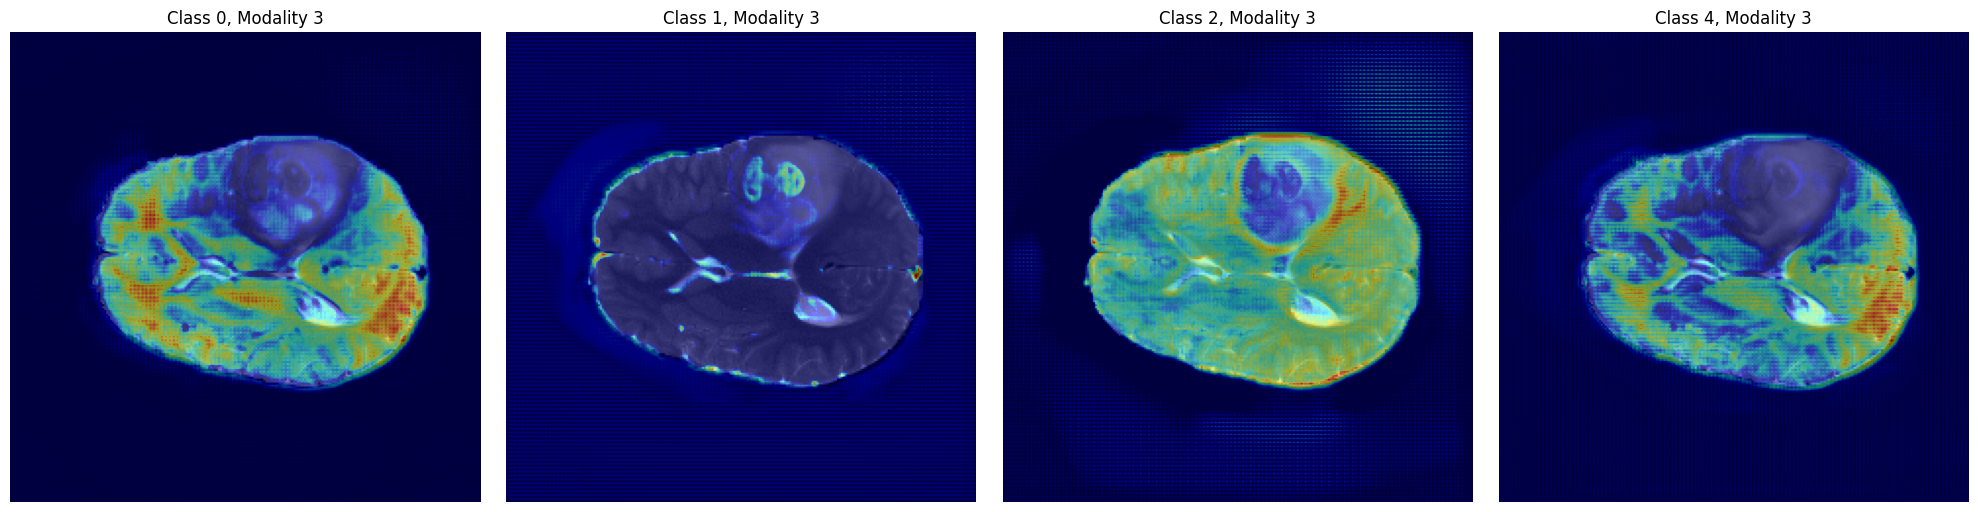

In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Function

class GradCam:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.model.eval()
        self.target_layer_name = target_layer_name
        self.gradients = None
        self.activations = None
        self.forward_hook = None
        self.backward_hook = None
        self._register_hooks()

    def _register_hooks(self):
        # Register forward and backward hooks to capture activations and gradients
        found = False
        for name, module in self.model.named_modules():
            if name == self.target_layer_name:
                # Confirm the layer is found
                print(f"Registering hooks on layer: {name}")
                self.forward_hook = module.register_forward_hook(self._forward_hook)
                self.backward_hook = module.register_backward_hook(self._backward_hook)
                found = True
                break
        if not found:
            raise ValueError(f"Layer {self.target_layer_name} not found in the model.")

    def _forward_hook(self, module, input, output):
        self.activations = output.detach()

    def _backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def generate_heatmap(self, input_image, target_class):
        self.model.zero_grad()
        mm_output, output = self.model(input_image)
        # Assume output is of shape [B, T, C_out, H, W]
        # Get the prediction for the last time step and the target class
        logits = output[:, -1, target_class, :, :].mean()
        logits.backward()

        gradients = self.gradients  # [B, C, H, W]
        activations = self.activations  # [B, C, H, W]
        B, C, H, W = gradients.size()

        # Compute weights
        weights = gradients.view(B, C, -1).mean(dim=2)  # [B, C]

        # Compute Grad-CAM
        cam = torch.zeros(B, H, W).to(gradients.device)
        for i in range(B):
            cam[i] = torch.sum(weights[i][:, None, None] * activations[i], dim=0)

        cam = F.relu(cam)  # Apply ReLU to the combined heatmap

        # Normalize the heatmap to [0, 1]
        cam_min = cam.view(B, -1).min(dim=1)[0].view(B, 1, 1)
        cam_max = cam.view(B, -1).max(dim=1)[0].view(B, 1, 1)
        cam = (cam - cam_min) / (cam_max - cam_min + 1e-8)
        cam = cam.unsqueeze(1)  # [B, 1, H, W]
        return cam

    def remove_hooks(self):
        self.forward_hook.remove()
        self.backward_hook.remove()

def visualize_grad_cam_classes(model, input_image, device, target_classes, temporal_idx=0, modal_idx=3):
    # Ensure the target layer name corresponds to a layer in your model
    target_layer_name = 'mmunet.upLayer4.conv.conv2'
    grad_cam = GradCam(model, target_layer_name)

    input_image = input_image.to(device)
    input_image.requires_grad = True

    num_classes = len(target_classes)
    fig, axes = plt.subplots(1, num_classes, figsize=(5*num_classes, 5))

    # Ensure axes is a 1D array
    if num_classes == 1:
        axes = np.array([axes])

    for idx, target_class in enumerate(target_classes):
        # Generate heatmap
        heatmap = grad_cam.generate_heatmap(input_image, target_class)
        grad_cam.remove_hooks()  # Remove hooks to reset for next iteration

        heatmap_np = heatmap.cpu().numpy()  # [B, 1, H, W]
        specific_heatmap = heatmap_np[0, 0]  # Assuming batch size is 1

        # Get the corresponding input image
        input_image_np = input_image.detach().cpu().numpy()  # [B, T, C, H, W]
        specific_image = input_image_np[0, temporal_idx, modal_idx]  # [H, W]

        # Normalize the input image for visualization
        specific_image_min = specific_image.min()
        specific_image_max = specific_image.max()
        if specific_image_max == specific_image_min:
            specific_image_norm = specific_image.copy()
        else:
            specific_image_norm = (specific_image - specific_image_min) / (specific_image_max - specific_image_min)

        # Overlay heatmap on the normalized input image
        ax = axes[idx]
        ax.imshow(specific_image_norm, cmap='gray')
        ax.imshow(specific_heatmap, cmap='jet', alpha=0.5)
        ax.axis('off')
        ax.set_title(f'Class {target_class}, Modality {modal_idx}', fontsize=12)

        # Re-register hooks for next iteration
        grad_cam._register_hooks()

    plt.tight_layout()
    plt.show()

# Prepare your model and data
model_not_noisy.eval()

# Select a batch from the test_loader
for batch_idx, (images, labels, names) in enumerate(test_loader_not_noisy):
    if batch_idx == 3:
        # Select temporal indices from the middle of the volume
        D = images.size(1)  # Temporal depth
        temporal_length = 4
        temporal_start = D // 2 - temporal_length // 2
        temporal_end = temporal_start + temporal_length
        if temporal_start < 0:
            temporal_start = 0
            temporal_end = temporal_length
        if temporal_end > D:
            temporal_end = D
            temporal_start = D - temporal_length
        image = images[:, temporal_start:temporal_end, ...]
        break  # Visualize just one batch

# Move image to CPU for visualization
image = image.cpu()

# Define the classes to visualize
target_classes = [0, 1, 2, 4]
modal_idx = 3  # Fixed modality index 3

# Call the visualize_grad_cam_classes function
visualize_grad_cam_classes(model_not_noisy, image, device, target_classes=target_classes, temporal_idx=0, modal_idx=modal_idx)

In [13]:
# Prepare your model and data
model_not_noisy.eval()

# Select a batch from the test_loader
for batch_idx, (images, labels, names) in enumerate(test_loader_not_noisy):
    if batch_idx == 3:
        # Select temporal indices from the middle of the volume
        D = images.size(1)  # Temporal depth
        temporal_length = 4
        temporal_start = D // 2 - temporal_length // 2
        temporal_end = temporal_start + temporal_length
        if temporal_start < 0:
            temporal_start = 0
            temporal_end = temporal_length
        if temporal_end > D:
            temporal_end = D
            temporal_start = D - temporal_length
        image = images[:, temporal_start:temporal_end, ...]
        label = labels[:, temporal_start:temporal_end, ...]
        break  # Visualize just one batch

# Move image to CPU for visualization
image = image.cpu()

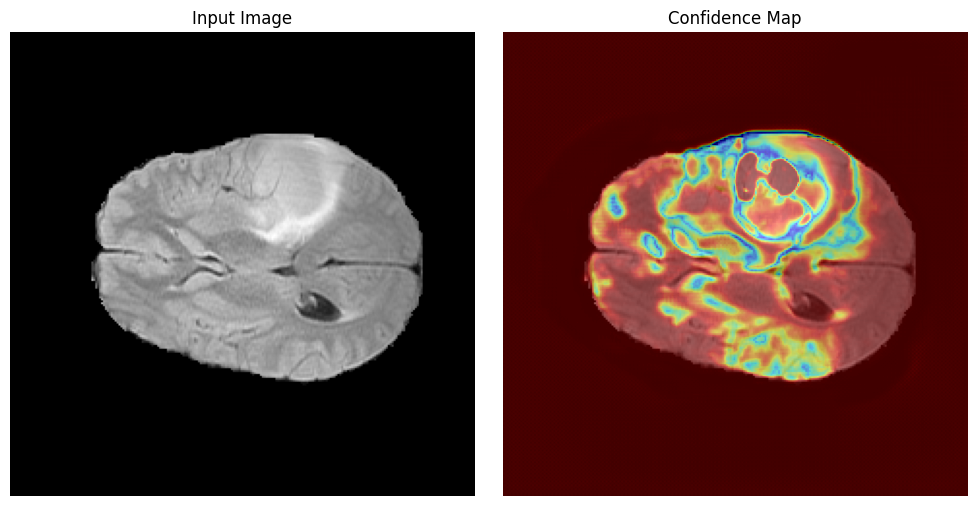

In [10]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def visualize_confidence_map(model, input_image, device, temporal_idx=0, modal_idx=0):
    """
    Visualizes the model's confidence map for the last time step.

    Parameters:
    - model: The trained model.
    - input_image: Input tensor of shape [B, T, C, H, W].
    - device: The device to run computations on (cpu or cuda).
    - temporal_idx: The temporal index to select.
    - modal_idx: The modality index to select.
    """

    input_image = input_image.to(device)

    # Forward pass
    model.eval()
    with torch.no_grad():
        _, output = model(input_image)  # Output shape: [B, T, C_out, H, W]
        output_probs = F.softmax(output[:, -1], dim=1)  # Softmax over classes

    # Get the maximum probability (confidence) and predicted class per pixel
    confidence, preds = torch.max(output_probs, dim=1)  # [B, H, W]

    # Move data to CPU
    confidence_np = confidence.cpu().numpy()
    preds_np = preds.cpu().numpy()
    input_image_np = input_image.detach().cpu().numpy()

    # Select the images
    confidence_map = confidence_np[0]  # [H, W]
    specific_image = input_image_np[0, temporal_idx, modal_idx]  # [H, W]

    # Normalize the input image for visualization
    specific_image_min = specific_image.min()
    specific_image_max = specific_image.max()
    if specific_image_max == specific_image_min:
        specific_image_norm = specific_image.copy()
    else:
        specific_image_norm = (specific_image - specific_image_min) / (specific_image_max - specific_image_min)

    # Display the confidence map overlayed on the input image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(specific_image_norm, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(specific_image_norm, cmap='gray')
    plt.imshow(confidence_map, cmap='jet', alpha=0.5)
    plt.title('Confidence Map')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_confidence_map(model_not_noisy, image, device, temporal_idx=0, modal_idx=0)

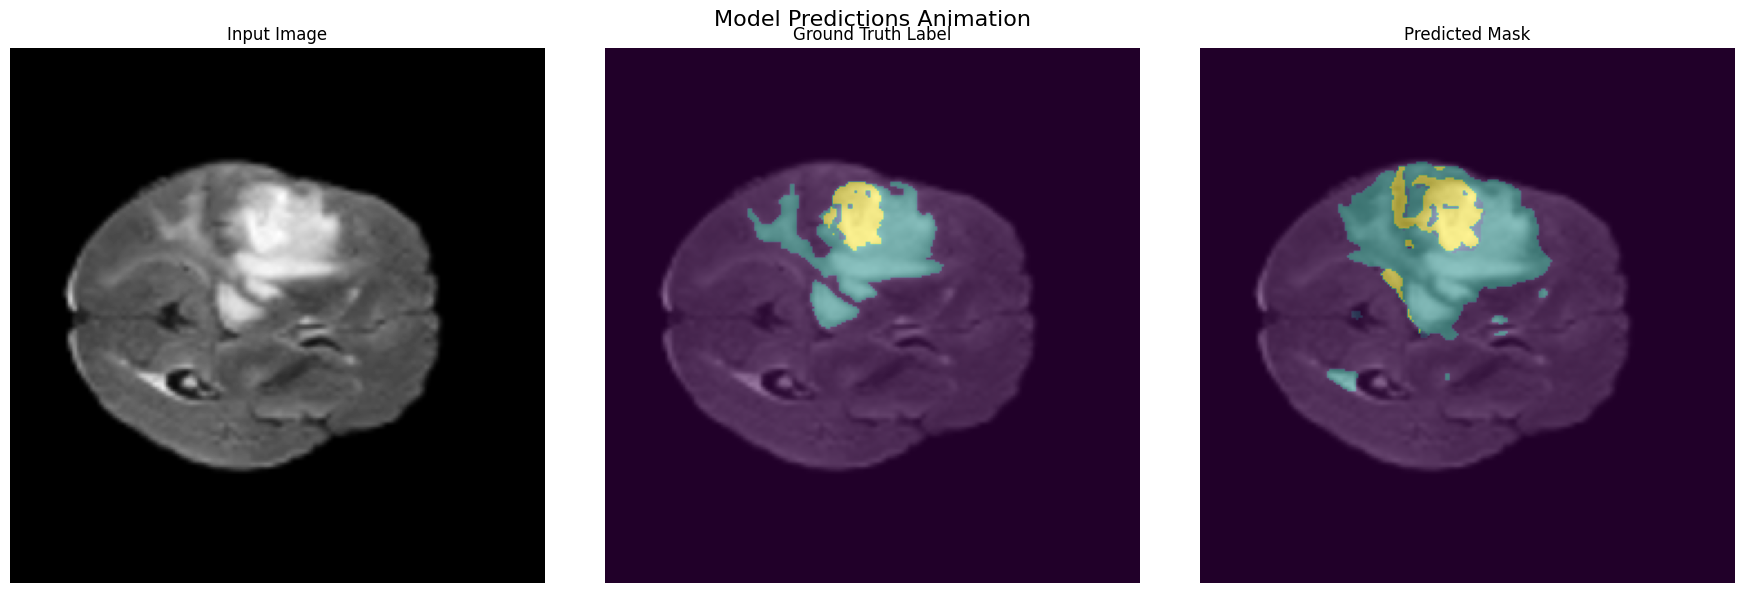

Animation saved to animation.mp4


In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def create_animation(model, test_loader, device, temporal_length=4, modal_idx=0, title='Model Predictions Animation', save_path=None):
    """
    Creates an animation over the temporal dimension of the given images, labels, and predictions.

    Parameters:
    - model: The trained model to use for predictions.
    - test_loader: The DataLoader for the test dataset.
    - device: The device to run the model on (cpu or cuda).
    - temporal_length: The length of the temporal sequence to visualize.
    - modal_idx: The index of the modality to visualize (default is 0).
    - title: Title of the animation.
    - save_path: If provided, the animation will be saved to this path.
    """
    model.eval()
    
    # Select a batch from the test_loader
    for batch_idx, (images, labels, names) in enumerate(test_loader):
        if batch_idx == 2:
            images = images.to(device)
            labels = labels.to(device)
            B, D, C, H, W = images.shape  # B: batch size, D: temporal depth, C: number of modalities

            # Select a temporal window to pass through the model
            temporal_start = D // 2 - temporal_length // 2
            temporal_end = temporal_start + temporal_length

            # Ensure we don't exceed the depth
            if temporal_start < 0:
                temporal_start = 0
                temporal_end = temporal_length
            if temporal_end > D:
                temporal_end = D
                temporal_start = D - temporal_length
            
            image_seq = images[:, temporal_start:temporal_end, :, :, :]  # Shape [B, T, C, H, W]
            label_seq = labels[:, temporal_start:temporal_end, :, :]      # Shape [B, T, H, W]
            
            # Run the model
            with torch.no_grad():
                _, output_seq = model(image_seq)  # Output shape: [B, T, C_out, H, W]
            preds_seq = torch.argmax(output_seq, dim=2)  # Predicted mask, shape: [B, T, H, W]
            break  # Visualize just one batch

    # Convert tensors to numpy arrays for visualization
    image_np = image_seq.cpu().numpy()
    label_np = label_seq.cpu().numpy()
    preds_np = preds_seq.cpu().numpy()

    # Since batch size is 1, extract the first sample
    images = image_np[0]  # Shape: [T, C, H, W]
    labels = label_np[0]  # Shape: [T, H, W]
    preds = preds_np[0]   # Shape: [T, H, W]

    num_timesteps = images.shape[0]
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Initialize the plots
    im0 = axes[0].imshow(images[0, modal_idx], cmap='gray', animated=True)
    
    im1 = axes[1].imshow(images[0, modal_idx], cmap='gray', animated=True)
    gt_overlay = axes[1].imshow(labels[0], cmap='viridis', alpha=0.5, vmin=0, vmax=4, animated=True)
    
    im2 = axes[2].imshow(images[0, modal_idx], cmap='gray', animated=True)
    pred_overlay = axes[2].imshow(preds[0], cmap='viridis', alpha=0.5, vmin=0, vmax=4, animated=True)
    
    axes[0].set_title('Input Image')
    axes[1].set_title('Ground Truth Label')
    axes[2].set_title('Predicted Mask')
    
    for ax in axes:
        ax.axis('off')
    
    fig.suptitle(title, fontsize=16)
    
    def init():
        im0.set_data(images[0, modal_idx])
        im1.set_data(images[0, modal_idx])
        gt_overlay.set_array(labels[0])
        im2.set_data(images[0, modal_idx])
        pred_overlay.set_array(preds[0])
        return [im0, im1, gt_overlay, im2, pred_overlay]
    
    def animate(i):
        im0.set_data(images[i, modal_idx])
        im1.set_data(images[i, modal_idx])
        gt_overlay.set_array(labels[i])
        im2.set_data(images[i, modal_idx])
        pred_overlay.set_array(preds[i])
        return [im0, im1, gt_overlay, im2, pred_overlay]
    
    ani = animation.FuncAnimation(fig, animate, frames=num_timesteps, init_func=init,
                                  interval=500, blit=True)
    
    # Show the animation
    plt.tight_layout()
    plt.show()
    
    # Save the animation
    if save_path is not None:
        ani.save(save_path, writer='ffmpeg', dpi=100)
        print(f'Animation saved to {save_path}')

create_animation(model_noisy, test_loader_noisy, device, temporal_length=4, modal_idx=0, title='Model Predictions Animation', save_path='animation.mp4')

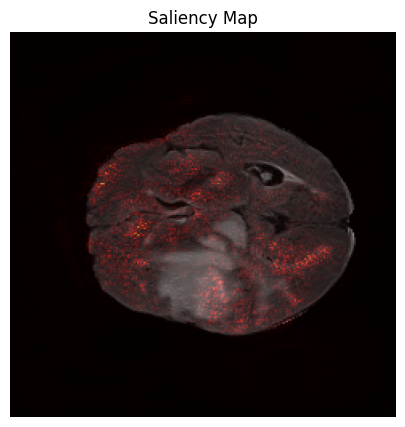

In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

def compute_saliency_maps(model, input_image, target_class, device, temporal_idx=0, modal_idx=0):
    """
    Computes saliency maps for the given input image and target class.

    Parameters:
    - model: The trained model.
    - input_image: Input tensor of shape [B, T, C, H, W].
    - target_class: The target class index for which to compute the saliency.
    - device: The device to run computations on (cpu or cuda).
    - temporal_idx: The temporal index to select (default is 0).
    - modal_idx: The modality index to select (default is 0).

    Returns:
    - saliency_map: The computed saliency map for the input image.
    - specific_image: The input image corresponding to the saliency map.
    """
    model.eval()
    input_image = input_image.to(device)
    input_image.requires_grad_()  # Enable gradient computation with respect to input

    # Forward pass
    _, output = model(input_image)
    # output shape: [B, T, C_out, H, W]
    # Get the prediction for the last time step and the target class
    logits = output[:, -1, target_class, :, :]  # Shape: [B, H, W]
    score = logits.mean()  # Take the mean over spatial dimensions

    # Backward pass
    model.zero_grad()
    score.backward()

    # Get saliency map
    saliency = input_image.grad.data.abs().detach().cpu()  # Shape: [B, T, C, H, W]
    # Select the specific time step and modality
    saliency_map = saliency[0, temporal_idx, modal_idx, :, :]  # Shape: [H, W]

    # Get the corresponding input image
    input_image_np = input_image.detach().cpu().numpy()
    specific_image = input_image_np[0, temporal_idx, modal_idx, :, :]  # Shape: [H, W]

    # Normalize the saliency map for visualization
    saliency_map_max = saliency_map.max()
    if saliency_map_max == 0:
        saliency_map_max = 1e-8  # Prevent division by zero
    saliency_map = saliency_map / saliency_map_max

    return saliency_map, specific_image

def visualize_saliency_map(saliency_map, specific_image, title='Saliency Map'):
    """
    Visualizes the saliency map overlayed on the input image.

    Parameters:
    - saliency_map: The computed saliency map.
    - specific_image: The input image corresponding to the saliency map.
    - title: Title for the plot.
    """
    # Normalize the input image for visualization
    specific_image_min = specific_image.min()
    specific_image_max = specific_image.max()
    if specific_image_max == specific_image_min:
        specific_image_norm = specific_image.copy()  # Avoid division by zero
    else:
        specific_image_norm = (specific_image - specific_image_min) / (specific_image_max - specific_image_min)

    plt.figure(figsize=(10, 5))
    plt.imshow(specific_image_norm, cmap='gray')
    plt.imshow(saliency_map, cmap='hot', alpha=0.5)
    plt.title(title)
    plt.axis('off')
    plt.show()


# Select a batch from the test_loader
for batch_idx, (images, labels, names) in enumerate(test_loader_not_noisy):
    if batch_idx == 2:
        images = images.to(device)
        labels = labels.to(device)
        B, D, C, H, W = images.shape  # B: batch size, D: temporal depth, C: number of modalities
        # Select a temporal window of length T (e.g., 4)
        temporal_length = 4
        temporal_start = D // 2 - temporal_length // 2
        temporal_end = temporal_start + temporal_length
        # Adjust indices if necessary
        if temporal_start < 0:
            temporal_start = 0
            temporal_end = temporal_length
        if temporal_end > D:
            temporal_end = D
            temporal_start = D - temporal_length
        input_sequence = images[:, temporal_start:temporal_end, :, :, :]  # Shape: [B, T, C, H, W]
        break  # Use this batch for visualization

# Compute the saliency map
target_class = 4  
temporal_idx = 0  
modal_idx = 0     

saliency_map, specific_image = compute_saliency_maps(
    model=model_not_noisy,
    input_image=input_sequence,
    target_class=target_class,
    device=device,
    temporal_idx=temporal_idx,
    modal_idx=modal_idx
)

# Visualize the saliency map
visualize_saliency_map(saliency_map, specific_image, title='Saliency Map')